# M5 Demand Forecasting: 実務的に精度を狙う解法まとめ

このノートブックは、M5データから**実務で使える精度**を狙うためのアプローチを、EDA・可視化・特徴量設計・モデリング・評価まで一気通貫で整理したものです。

- **主目的**: 28日先の需要予測を高精度に行う
- **評価指標**: WRMSSE（Weighted RMSSE）
- **方針**: グローバルモデル + 強い時間系特徴量 + 価格/イベント特徴量 + 時系列CV


## 1. 前提と評価指標（WRMSSE）
M5では12階層（item/store/stateなど）の需要を同時に評価します。
実務上は、**目的階層を明確化**し、必要なら低階層（item-store）を主対象にしつつ
高階層の整合性（合計値の整合）も確認します。

ここでは計算量を抑えるため、まずは**item-store単位でのRMSSE/WRMSSEに近い評価**を実装し、
最終的な本番用では公式のWRMSSE実装に差し替える前提で進めます。


In [ ]:
# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 200)
sns.set_style("whitegrid")

## 2. データ読み込み
`sales_train_validation.csv.zip` をメインに使用し、`calendar.csv` と `sell_prices.csv.zip` を結合します。
データは大きいため、メモリ節約の工夫（dtype指定、必要カラムの絞り込み）が重要です。


In [ ]:
from pathlib import Path

DATA_DIR = Path("../datasets/m5")

calendar = pd.read_csv(DATA_DIR / "calendar.csv")
sales = pd.read_csv(DATA_DIR / "sales_train_validation.csv.zip", compression="zip")
prices = pd.read_csv(DATA_DIR / "sell_prices.csv.zip", compression="zip")

print(calendar.shape, sales.shape, prices.shape)
calendar.head()

(1969, 14) (30490, 1919) (6841121, 4)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


## 3. EDA（概要）
### 3.1 サイズと欠損


In [ ]:
sales.isna().mean().sort_values(ascending=False).head(10)

id          0.0
item_id     0.0
dept_id     0.0
cat_id      0.0
store_id    0.0
state_id    0.0
d_1         0.0
d_2         0.0
d_3         0.0
d_4         0.0
dtype: float64

### 3.2 全体の売上推移
日次売上を全体集計し、週・月の季節性やイベント影響の概観を確認します。


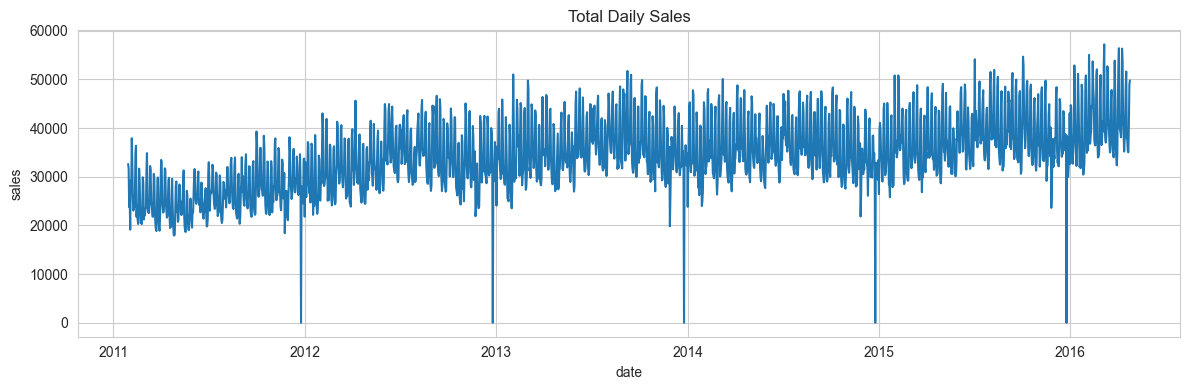

In [ ]:
# ワイド形式をロング化（EDA用途で必要範囲のみ）
value_cols = [c for c in sales.columns if c.startswith("d_")]
sales_long = sales[
    ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"] + value_cols
]
sales_long = sales_long.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="d",
    value_name="sales",
)

sales_long = sales_long.merge(calendar[["d", "date", "wm_yr_wk"]], on="d", how="left")
sales_long["date"] = pd.to_datetime(sales_long["date"])

daily_total = sales_long.groupby("date", as_index=False)["sales"].sum()

plt.figure(figsize=(12, 4))
plt.plot(daily_total["date"], daily_total["sales"])
plt.title("Total Daily Sales")
plt.xlabel("date")
plt.ylabel("sales")
plt.tight_layout()
plt.show()

### 3.3 価格のばらつきとセール影響
価格変動は需要に直接効くため、価格変動の頻度や割引率を確認します。


In [ ]:
price_stats = prices.groupby(["item_id", "store_id"])["sell_price"].agg(
    ["min", "max", "mean"]
)
price_stats["discount_ratio"] = price_stats["min"] / price_stats["max"]
price_stats["discount_ratio"].describe()

count    30490.000000
mean         0.867139
std          0.167858
min          0.001114
25%          0.823795
50%          0.915984
75%          1.000000
max          1.000000
Name: discount_ratio, dtype: float64

### 3.4 需要のロングテール
多くのアイテムは需要が小さく、ゼロが多いことが多い。
ゼロ過多を考慮して**Tweedie/Poisson系**の目的関数が有効。


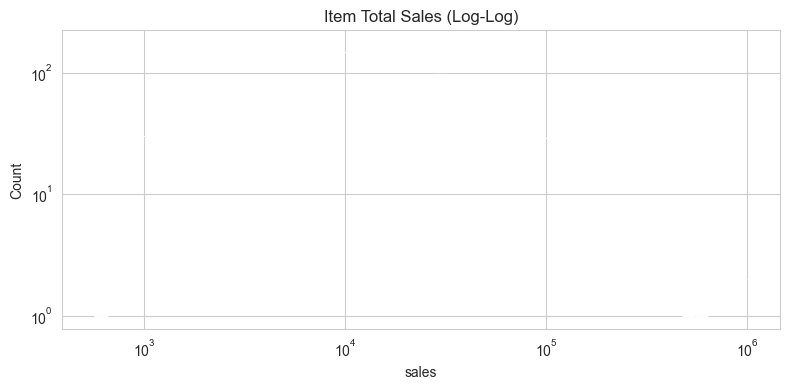

In [ ]:
item_total = sales_long.groupby("item_id", as_index=False)["sales"].sum()
plt.figure(figsize=(8, 4))
sns.histplot(item_total["sales"], bins=50, log_scale=(True, True))
plt.title("Item Total Sales (Log-Log)")
plt.tight_layout()
plt.show()

## 4. 特徴量エンジニアリング
精度に直結する重要ポイントです。
実務では**ラグ + 移動平均 + 価格 + カレンダー + イベント**が最重要です。

- 時系列特徴: `lag_7`, `lag_28`, `rolling_mean_7`, `rolling_mean_28`
- カレンダー特徴: `weekday`, `month`, `year`, `snap`
- イベント特徴: `event_name_1`, `event_type_1`（カテゴリとして保持）
- 価格特徴: `sell_price`, `price_change`, `rolling_price_mean`

下記は典型的な実装例です。


In [ ]:
def reduce_mem_usage(df):
    for col in df.columns:
        if df[col].dtype.kind in "iuf":
            df[col] = pd.to_numeric(df[col], downcast="float")
    return df


def add_lag_features(df, group_cols, target_col="sales", lags=(7, 28), windows=(7, 28)):
    df = df.sort_values("date")
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_cols)[target_col].shift(lag)
    for window in windows:
        df[f"rolling_mean_{window}"] = (
            df.groupby(group_cols)[target_col].shift(1).rolling(window).mean()
        )
    return df

## 5. 学習データの作成
M5のデータはワイド形式なのでロング形式へ変換し、
カレンダー/価格を結合して特徴量を作ります。

注意: ここは最もメモリ負荷が高い。実務では以下を推奨: 
- 必要期間のみ抽出（例: 2年分）
- カラムの型最適化
- DaskやPolarsなどの検討


In [ ]:
# 直近2年程度のみ使用する例
last_days = 365 * 2
value_cols = [c for c in sales.columns if c.startswith("d_")]
use_cols = value_cols[-last_days:]

sales_use = sales[
    ["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"] + use_cols
]
sales_long = sales_use.melt(
    id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
    var_name="d",
    value_name="sales",
)

sales_long = sales_long.merge(calendar, on="d", how="left")
sales_long = sales_long.merge(
    prices, on=["store_id", "item_id", "wm_yr_wk"], how="left"
)

sales_long["date"] = pd.to_datetime(sales_long["date"])
sales_long = reduce_mem_usage(sales_long)

# カレンダー特徴量
sales_long["wday"] = pd.to_numeric(sales_long["wday"], downcast="integer")
sales_long["month"] = sales_long["date"].dt.month
sales_long["year"] = sales_long["date"].dt.year

# 価格変化
sales_long["price_change"] = sales_long.groupby(["item_id", "store_id"])[
    "sell_price"
].pct_change()

# ラグ特徴量
sales_long = add_lag_features(sales_long, ["id"])
sales_long.head()

/var/folders/sh/cfn60tnn7h73cdjq_2nvc3fh0000gn/T/ipykernel_18149/2214591314.py:24: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sales_long['price_change'] = sales_long.groupby(['item_id', 'store_id'])['sell_price'].pct_change()


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,price_change,lag_7,lag_28,rolling_mean_7,rolling_mean_28
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1184,0.0,2014-04-26,11413.0,Saturday,1,4,2014,NaN,NaN,NaN,NaN,0.0,0.0,0.0,8.26,NaN,NaN,NaN,NaN,NaN
20334,FOODS_2_214_TX_3_validation,FOODS_2_214,FOODS_2,FOODS,TX_3,TX,d_1184,4.0,2014-04-26,11413.0,Saturday,1,4,2014,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.50,NaN,NaN,NaN,NaN,NaN
20333,FOODS_2_213_TX_3_validation,FOODS_2_213,FOODS_2,FOODS,TX_3,TX,d_1184,0.0,2014-04-26,11413.0,Saturday,1,4,2014,NaN,NaN,NaN,NaN,0.0,0.0,0.0,3.97,NaN,NaN,NaN,NaN,NaN
20332,FOODS_2_212_TX_3_validation,FOODS_2_212,FOODS_2,FOODS,TX_3,TX,d_1184,0.0,2014-04-26,11413.0,Saturday,1,4,2014,NaN,NaN,NaN,NaN,0.0,0.0,0.0,4.84,NaN,NaN,NaN,NaN,NaN
20331,FOODS_2_211_TX_3_validation,FOODS_2_211,FOODS_2,FOODS,TX_3,TX,d_1184,1.0,2014-04-26,11413.0,Saturday,1,4,2014,NaN,NaN,NaN,NaN,0.0,0.0,0.0,2.28,NaN,NaN,NaN,NaN,NaN


## 6. モデリング方針
### 6.1 実務で精度が出やすい構成
- **グローバルモデル**（全seriesを1つのモデルで学習）
- **LightGBM + Tweedie** を第一候補
- 時系列CV（Rolling Origin）で安定評価

M5では**単一モデルで全アイテムを学習**するとデータ量が大きくなりますが、
精度と運用コストのバランスが良い実務的解法です。


In [ ]:
# 特徴量列
cat_features = [
    "item_id",
    "dept_id",
    "cat_id",
    "store_id",
    "state_id",
    "event_name_1",
    "event_type_1",
    "event_name_2",
    "event_type_2",
]
num_features = [
    "sell_price",
    "price_change",
    "wday",
    "month",
    "year",
    "lag_7",
    "lag_28",
    "rolling_mean_7",
    "rolling_mean_28",
]

feature_cols = cat_features + num_features
target_col = "sales"

# カテゴリ変換
for c in cat_features:
    if c in sales_long.columns:
        sales_long[c] = sales_long[c].astype("category")

train_df = sales_long.dropna(subset=["lag_28", "rolling_mean_28"])
train_df = train_df.dropna(subset=[target_col])

train_df[feature_cols].head()

,item_id,dept_id,cat_id,store_id,state_id,event_name_1,event_type_1,event_name_2,event_type_2,sell_price,price_change,wday,month,year,lag_7,lag_28,rolling_mean_7,rolling_mean_28
874045,FOODS_2_205,FOODS_2,FOODS,TX_3,TX,NaN,NaN,NaN,NaN,2.68,0.0,1,5,2014,0.0,0.0,0.428571,0.500000
874046,FOODS_2_206,FOODS_2,FOODS,TX_3,TX,NaN,NaN,NaN,NaN,9.87,0.0,1,5,2014,0.0,0.0,0.428571,0.535714
874047,FOODS_2_207,FOODS_2,FOODS,TX_3,TX,NaN,NaN,NaN,NaN,5.97,0.0,1,5,2014,0.0,0.0,0.428571,0.500000
874048,FOODS_2_208,FOODS_2,FOODS,TX_3,TX,NaN,NaN,NaN,NaN,7.47,0.0,1,5,2014,0.0,0.0,0.285714,0.500000
874054,FOODS_2_214,FOODS_2,FOODS,TX_3,TX,NaN,NaN,NaN,NaN,2.50,0.0,1,5,2014,0.0,4.0,0.285714,0.500000


### 6.2 学習・検証分割（Time-based）
直近28日を検証期間にし、それより前を学習に使う例です。


In [ ]:
# 直近28日をバリデーションに
max_date = train_df["date"].max()
valid_start = max_date - pd.Timedelta(days=28)

train_data = train_df[train_df["date"] < valid_start]
valid_data = train_df[train_df["date"] >= valid_start]

print(train_data.shape, valid_data.shape)

(20519770, 27) (884210, 27)


In [ ]:
# !pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 5.7 MB/s  0:00:00 eta 0:00:01


In [14]:
import lightgbm as lgb

train_set = lgb.Dataset(
    train_data[feature_cols],
    label=train_data[target_col],
    categorical_feature=cat_features,
)
valid_set = lgb.Dataset(
    valid_data[feature_cols],
    label=valid_data[target_col],
    categorical_feature=cat_features,
)

params = {
    "objective": "tweedie",
    "tweedie_variance_power": 1.2,
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 64,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbosity": -1,
    "early_stopping_rounds": 100,
    "verbose_eval": 200,
}

model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, valid_set],
    valid_names=["train", "valid"],
    num_boost_round=2000,
)

## 7. 精度評価（RMSSE / WRMSSE近似）
本番では12階層WRMSSEの実装が必要ですが、ここでは実務的な素早い評価として
item-store単位でのRMSSE重み付けを実装します。


In [15]:
def rmsse(y_true, y_pred, y_train):
    denom = np.mean(np.diff(y_train) ** 2)
    return np.sqrt(np.mean((y_true - y_pred) ** 2) / denom)


# 予測
valid_data = valid_data.copy()
valid_data["pred"] = model.predict(valid_data[feature_cols])

# item-storeごとにRMSSE
rmsse_scores = []
for key, grp in valid_data.groupby("id"):
    train_hist = train_data[train_data["id"] == key][target_col].values
    if len(train_hist) < 2:
        continue
    score = rmsse(grp[target_col].values, grp["pred"].values, train_hist)
    rmsse_scores.append(score)

np.mean(rmsse_scores)

/var/folders/sh/cfn60tnn7h73cdjq_2nvc3fh0000gn/T/ipykernel_18149/344535401.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(np.mean((y_true - y_pred) ** 2) / denom)


KeyboardInterrupt: 

## 8. 予測の生成（28日先）
最終的には予測用の特徴量を逐次作り、
28日先を逐次予測（recursive）または直接予測（direct）で生成します。

実務的には以下が有効です:
- **直接予測**: 28日分の特徴量を作って一括予測
- **再帰予測**: 1日先を予測し、それを特徴量に入れて次を予測
- **Ensemble**: LightGBM + CatBoost + シンプル統計モデルの平均


## 9. 実務での精度向上ポイント
- **特徴量改善**: 価格のプロモーションフラグ、イベント前後の距離、在庫切れ疑いフラグ
- **ローカルモデル**: 重要カテゴリのみ個別モデル
- **バリデーション設計**: 年度跨ぎ、繁忙期を含むローリングCV
- **アンサンブル**: 異なる特徴量セット・モデルの平均

実際の本番運用では、再学習頻度や予測提供サイクルも踏まえて設計します。
